In [1]:
import datetime
import pyproj
from sklearn.cluster.dbscan_ import DBSCAN
import numpy as np


from gda_sdm_functions import read_data, plot_nb_dists, plot_cluster, export_to_shp


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.dbscan_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kd_tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Path to geodatabase
input_file = "taxi_21.txt"


# source projection
proj_wgs84 = pyproj.Proj("+init=EPSG:4326")

# target protection
proj_target = pyproj.Proj("+init=EPSG:25833") # 3004 monte mario 2


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [3]:
def transform(data_in):

    data_out = []
    
    t_reference = datetime.datetime(2014,1,1)

    for d in data_in:
        x = d[0]
        y = d[1]
        ts = d[2]

        x, y = pyproj.transform(proj_wgs84, proj_target, x, y)
        
        ts = ((ts-t_reference).total_seconds())/60

        data_out.append([x, y, ts])
    
    return data_out


In [4]:
def dbscan(X, eps=15, min_samples=5, metric='cityblock'):
    """ Function derived from scipy dbscan example
    http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#example-cluster-plot-dbscan-py
    """

    X = np.array(data)

    ##########################################################################
    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(X)
    
    labels = db.labels_
    core_samples_indices = db.core_sample_indices_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    print('Estimated number of clusters: %d' % n_clusters_)

    return labels, core_samples_indices


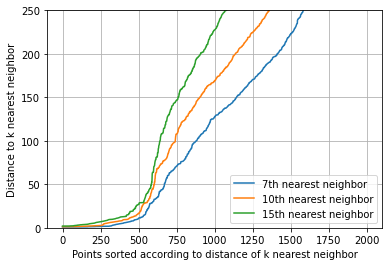

Estimated number of clusters: 17


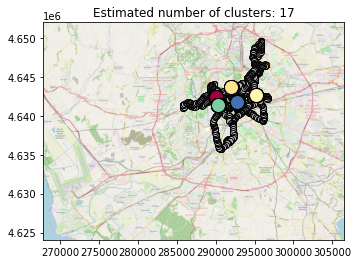

done


In [5]:
if __name__ == '__main__':

    # Read data
    org_data = read_data(input_file, 2000)

    # Apply transformations
    data = transform(org_data)

    metric = 'chebyshev'
    data = np.array(data)

    # plot nearest neighbor distances diagram
    plot_nb_dists(data, nearest_neighbor=[7,10,15], metric=metric, ylim=250)
    
    # set parameters
    eps = 5
    min_samples = 10
    
    # Calculate clusters with dbscan
    labels, core_samples_indices = dbscan(data, eps=eps, min_samples=min_samples, metric=metric)
    
    # plot clusters
    plot_cluster(data, labels, core_samples_indices, proj_wgs84=proj_wgs84, proj_target=proj_target, linestyle='solid')

    
    # export clusters to geodatabase
    export_layer_name = "stops"
    export_to_shp(data, labels, export_layer_name, crs=proj_target.srs)
